# Machine Learning - Practical 3 - Multiclass Logistic Regression, MLP and CNNs


Names:  Rana Ashar Mehmood - Ahsan Ali - Muhammad Talha Abbas
Summer Term 2023   
Due Date: Tuesday, May 30, 2pm

**Please note that this practical requires training a lot of models, which may be time consuming (~2h)**

In this practical we will implement multiclass classification with classic Logistic Regression, Multilayer Preceptron, and the convolutional neural network LeNet5 on image data. We will compare the performance of these models. You will work on the following:

 1. Imports and Hardware check
 2. Loading data and related transformations 
 3. Defining training helper functions and metrics 
 4. Logistic Regression 
 5. MLP
 6. CNN
 7. Comparison of results across models

We'll be storing all the losses and accuracies while training, and plotting everything in the end. Use `tqdm` to keep track of your training and validation losses and accuracies since we're only plotting them in the end.

In [1]:
! pip install torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms

torch.manual_seed(42) # Set manual seed

In [3]:
# DO NOT CHANGE
use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'
print('Using device', device)

Using device cuda:0


## Define data transformations

We will work with the CIFAR-10 dataset, an established computer vision dataset used for object recognition. It is a subset of the 80 million tiny images dataset and consists of 60,000 32x32 color images containing one of 10 object classes, with 6000 images per class. It was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. The goal of this dataset is to predict the image class.

Note: The constants in `transforms.Normalize()` are the means and standard deviations of the three color channels of the images in the CIFAR-10 training set. You can verify these numbers yourself by re-computing them.

In [4]:
batch_size = 256

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [5]:
# Load the data and transform the dataset
train_dataset =  datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)

# You can verify the mean and standard deviation used in the normalization above by calculating the mean and std of the training dataset above.  
channel_mean = np.mean(train_dataset.data / 255, axis=(0, 1, 2))
channel_std = np.std(train_dataset.data / 255, axis=(0, 1, 2))

print("Mean:", channel_mean)
print("Std:", channel_std)

100%|██████████| 170498071/170498071 [00:06<00:00, 25159090.88it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Mean: [0.49139968 0.48215841 0.44653091]
Std: [0.24703223 0.24348513 0.26158784]


In [6]:
# TODO: make dataloaders (from torch.utils) from datasets, define batch size and do not forget shuffling 
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 

 

In [7]:
def show_batch(dl):
    # Get a batch of images and labels
    images, labels = next(iter(dl))
    
    # Denormalizing images
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    images = images * std[:, None, None] + mean[:, None, None]
    
    # Convert PyTorch tensors to NumPy arrays
    images = images.numpy()
    labels = labels.numpy()
    
    # Create a grid of images
    grid = np.transpose(images, (0, 2, 3, 1))
    grid = np.clip(grid, 0, 1)
    
    # Create a figure and axes
    fig, axes = plt.subplots(figsize=(10, 10), ncols=8, nrows=8)
    axes = axes.flatten()
    
    # Plot images with labels
    for i, ax in enumerate(axes):
        ax.imshow(grid[i])
        ax.axis('off')
        ax.set_title(str(labels[i]))
    
    plt.tight_layout()
    plt.show()

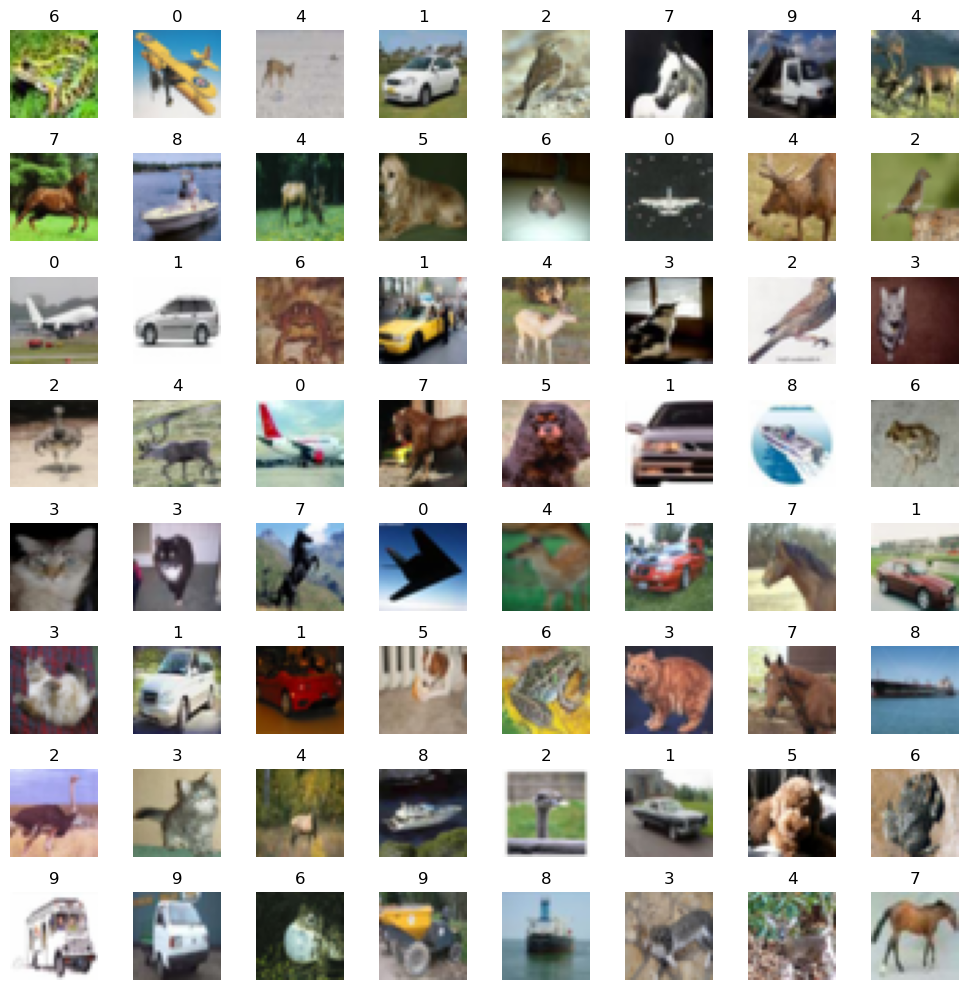

In [8]:
show_batch(train_loader)

In [9]:
num_classes = 10

## Define helper functions for training and metrics

You will need these again and again. 

In [10]:
## TODO: write a function that calculates the accuracy

def accuracy(correct, total): 
    """
    function to calculate the accuracy given the
        correct: number of correctly classified samples
        total: total number of samples
    returns the ratio
    """
    return correct / total

In [11]:
## TODO: Define a train and validation functions here
## Hint - you can use yours from Practical 2 
from tqdm import tqdm,trange

def train(dataloader, optimizer, model, loss_fn, device, master_bar):
    """Method to train the model"""

    model.train()  # Set the model to training mode

    losses = []
    total_correct = 0
    total_samples = 0
    
    loop = tqdm(dataloader,desc="Epochs", unit="epoch",total=len(dataloader), leave=False)

    for data, targets in loop:
        data = data.to(device)
        targets = targets.to(device)

        # Forward pass
        outputs = model(data)
        loss = loss_fn(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_samples += targets.size(0)
        total_correct += (predicted == targets).sum().item()

        # Save loss
        losses.append(loss.item())

        loop.set_description = f'Loss: {loss.item():.4f}'
        tqdm.close
    mean_loss = sum(losses) / len(losses)
    accuracy = total_correct / total_samples

    return mean_loss, accuracy


def validate(dataloader, model, loss_fn, device, master_bar):
    """Method to compute the metrics on the validation set"""

    model.eval()  # Set the model to evaluation mode

    losses = []
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        loop = tqdm(dataloader,desc="Epochs", unit="epoch",total=len(dataloader), leave=False)
        for data, targets in loop:
            data = data.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(data)
            loss = loss_fn(outputs, targets)

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_samples += targets.size(0)
            total_correct += (predicted == targets).sum().item()

            # Save loss
            losses.append(loss.item())

            tqdm.comment = f'Loss: {loss.item():.4f}'
            tqdm.close

    mean_loss = sum(losses) / len(losses)
    accuracy = total_correct / total_samples

    return mean_loss, accuracy


In [12]:
## TODO: Define a train and validation functions here
## Hint - you can use yours from Practical 2 
from tqdm import tqdm,trange

def train(dataloader, optimizer, model, loss_fn, device, master_bar):
    """Method to train the model"""

    model.train()  # Set the model to training mode

    losses = []
    total_correct = 0
    total_samples = 0
    
    loop = tqdm(dataloader,desc="Epochs", unit="epoch",total=len(dataloader), leave=False)

    for id,(data, targets) in enumerate(loop):
        data = data.to(device)
        targets = targets.to(device)

        # Forward pass
        outputs = model(data)
        loss = loss_fn(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_samples += targets.size(0)
        total_correct += (predicted == targets).sum().item()

        # Save loss
        losses.append(loss.item())

        loop.set_description = (f'Loss: {loss.item():.4f}')
        tqdm.close
    mean_loss = sum(losses) / len(losses)
    accuracy = total_correct / total_samples

    return mean_loss, accuracy


def validate(dataloader, model, loss_fn, device, master_bar):
    """Method to compute the metrics on the validation set"""

    model.eval()  # Set the model to evaluation mode

    losses = []
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        loop = tqdm(dataloader,desc="Epochs", unit="epoch",total=len(dataloader), leave=False)
        for data, targets in loop:
            data = data.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(data)
            loss = loss_fn(outputs, targets)

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_samples += targets.size(0)
            total_correct += (predicted == targets).sum().item()

            # Save loss
            losses.append(loss.item())

            tqdm.comment = f'Loss: {loss.item():.4f}'
            tqdm.close

    mean_loss = sum(losses) / len(losses)
    accuracy = total_correct / total_samples

    return mean_loss, accuracy


In [13]:
#TODO: write a run_training function that 
# - calls the train and validate functions for each epoch
# - saves the train_losses, val_losses, train_accs, val_accs as arrays for each epoch
## Hint - you can use yours from Practical 2 
from tqdm import tqdm,trange


def run_training(model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader):
    """Method to run the training procedure"""
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    master_bar = trange(num_epochs, unit="epoch", leave=False)

    for epoch in master_bar:
        # Training
        master_bar.set_description(f"Epoch {epoch}")
        train_loss, train_acc = train(train_dataloader, optimizer, model, loss_function, device,master_bar)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation
        val_loss, val_acc = validate(val_dataloader, model, loss_function, device, master_bar)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        master_bar.set_postfix(train_loss=train_loss, train_acc=train_acc, val_loss=val_loss, val_acc=val_acc)

    master_bar.close()

    return train_losses, val_losses, train_accs, val_accs

In [14]:
# TODO: write a function to calculate and return the confusion values
from sklearn.metrics import confusion_matrix
def calc_confusion_values(dataloader, model, device):
    """Method to compute the confusion values on the validation set"""

    model.eval()  # Set the model to evaluation mode

    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for data, targets in dataloader:
            data = data.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)

            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    confusion = confusion_matrix(all_targets, all_predictions)
    return confusion

## Logistic Regression   

In [15]:
class LR(torch.nn.Module):
    """
    Logistic regression model inherits from the torch.nn.Module 
    which is the base class for all neural network modules.
    """
    def __init__(self, input_dim, output_dim):
        """ Initializes internal Module state. """
        super(LR, self).__init__()
        
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        """ Defines the computation performed at every call. """
        # Flatten the input to a suitable size for the initial layer
        x = x.view(x.size(0), -1)
        
        # Pass the data through the linear layer
        outputs = self.linear(x)
        return outputs


In [16]:
## TODO: Define network in the variable named 'linear_regression', put it to the device and train mode
input_dim = 3072
output_dim = 10
linear_regression = LR(input_dim, output_dim)
linear_regression.to(device)
linear_regression.train()



LR(
  (linear): Linear(in_features=3072, out_features=10, bias=True)
)

In [17]:
## Optimiser defined. We're going to use Adam since it's always the safe bet, and also for faster convergence. 
optimizer = torch.optim.Adam(linear_regression.parameters(), lr=0.001)

### Define loss 

Since we're dealing with multi-class classification (i.e. multiple categories), softmax is the canonical choice for the final layer activation. Softmax provides us with a distribution of values in \[0, 1\] that sum up to 1 over all categories.

We then use the cross entropy to compute the loss.

Hint: Due to numerical reasons, softmax and cross entropy are combined into one operation. Read more about it in https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html.

In [18]:
# TODO: define the loss function
loss_fn = nn.CrossEntropyLoss()

In [19]:
num_epochs = 20
## TODO: run training over 20 epochs

train_losses_LR, val_losses_LR, train_accs_LR, val_accs_LR = run_training(linear_regression, optimizer, loss_fn, device, num_epochs, train_loader, test_loader)


Epochs: 100%|██████████| 196/196 [00:17<00:00, 14.49epoch/s]
                                                            
Epochs: 100%|██████████| 196/196 [00:14<00:00, 14.32epoch/s]
                                                            
Epochs: 100%|██████████| 196/196 [00:14<00:00, 14.85epoch/s]
                                                            
Epochs:  99%|█████████▉| 195/196 [00:15<00:00, 13.33epoch/s]
                                                            
Epochs: 100%|██████████| 196/196 [00:14<00:00, 15.10epoch/s]
                                                            
Epochs: 100%|██████████| 196/196 [00:15<00:00, 15.13epoch/s]
                                                            
Epochs: 100%|██████████| 196/196 [00:14<00:00, 14.37epoch/s]
                                                            
Epochs:  99%|█████████▉| 195/196 [00:16<00:00, 12.12epoch/s]
                                                            
Epochs: 100%|██████████|

## Multilayer Perceptron

MLP is a network which consists of several linear fully-connected layers with non-linearities between them.

### Question:
Why are non-linearities between linear layers important?

In [20]:
class MLP(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        ## TODO: Make the 4 layer MLP with the following shapes :
        ## input_dim -> 1650 -> 512 -> 138 -> output_dim
        ## Use RELu as nonlinearity
        super(MLP, self).__init__()

        self.fc1 = nn.Linear(input_dim, 1650)
        self.fc2 = nn.Linear(1650, 512)
        self.fc3 = nn.Linear(512, 138)
        self.fc4 = nn.Linear(138, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        ## TODO: write the forward pass
        ## Do not forget to flatten the input
        x = x.view(x.size(0), -1)  # Flatten the input tensor

        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)

        return x


In [21]:
## TODO: Define network, put it to device and train mode
mlp_model = MLP(input_dim, output_dim)

# Move the model to the device
mlp_model = mlp_model.to(device)

# Set the model to train mode
mlp_model.train()




MLP(
  (fc1): Linear(in_features=3072, out_features=1650, bias=True)
  (fc2): Linear(in_features=1650, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=138, bias=True)
  (fc4): Linear(in_features=138, out_features=10, bias=True)
  (relu): ReLU()
)

In [22]:
## TODO: Define optimizer and loss functions
learning_rate = 0.001
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=learning_rate)

# Define the loss function
criterion = nn.CrossEntropyLoss()

In [23]:
## TODO: Train the MLP over 20 epochs
train_losses_MLP, val_losses_MLP, train_accs_MLP, val_accs_MLP = run_training(mlp_model, optimizer, loss_fn, device, num_epochs, train_loader, test_loader)


Epochs:  99%|█████████▉| 195/196 [00:16<00:00, 12.36epoch/s]
                                                            
Epochs: 100%|██████████| 196/196 [00:15<00:00, 13.68epoch/s]
                                                            
Epochs:  99%|█████████▉| 195/196 [00:16<00:00, 12.86epoch/s]
                                                            
Epochs:  99%|█████████▉| 195/196 [00:15<00:00, 13.31epoch/s]
                                                            
Epochs:  99%|█████████▉| 195/196 [00:15<00:00, 13.28epoch/s]
                                                            
Epochs:  99%|█████████▉| 195/196 [00:15<00:00, 13.25epoch/s]
                                                            
Epochs:  99%|█████████▉| 195/196 [00:16<00:00, 13.06epoch/s]
                                                            
Epochs:  99%|█████████▉| 195/196 [00:15<00:00, 12.95epoch/s]
                                                            
Epochs: 100%|██████████|

## Add L2 regularisation

In [24]:
# TODO: Define new model, optimizer, put model to device, etc.
## 0.0005 is a good starting point for the regularization strength
## TODO: Define network, put it to device and train mode
mlp_model2 = MLP(input_dim, output_dim)

# Move the model to the device
mlp_model2 = mlp_model.to(device)

learning_rate = 0.001
weight_decay = 0.0005
optimizer = torch.optim.Adam(mlp_model2.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Set the model to train mode
mlp_model2.train()


MLP(
  (fc1): Linear(in_features=3072, out_features=1650, bias=True)
  (fc2): Linear(in_features=1650, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=138, bias=True)
  (fc4): Linear(in_features=138, out_features=10, bias=True)
  (relu): ReLU()
)

In [25]:
## TODO: Retrain new model with regularization over 20 epochs
num_epochs = 20
train_losses_MLP2, val_losses_MLP2, train_accs_MLP2, val_accs_MLP2 = run_training(mlp_model2, optimizer, loss_fn, device, num_epochs, train_loader, test_loader)

Epochs: 100%|██████████| 196/196 [00:15<00:00, 14.47epoch/s]
                                                            
Epochs:  99%|█████████▉| 195/196 [00:16<00:00, 13.21epoch/s]
                                                            
Epochs: 100%|██████████| 196/196 [00:15<00:00, 14.61epoch/s]
                                                            
Epochs:  99%|█████████▉| 195/196 [00:16<00:00, 13.09epoch/s]
                                                            
Epochs: 100%|██████████| 196/196 [00:15<00:00, 14.27epoch/s]
                                                            
Epochs:  99%|█████████▉| 195/196 [00:16<00:00, 12.72epoch/s]
                                                            
Epochs: 100%|██████████| 196/196 [00:15<00:00, 13.76epoch/s]
                                                            
Epochs: 100%|██████████| 196/196 [00:15<00:00, 13.65epoch/s]
                                                            
Epochs:  99%|█████████▉|

## LeNet5

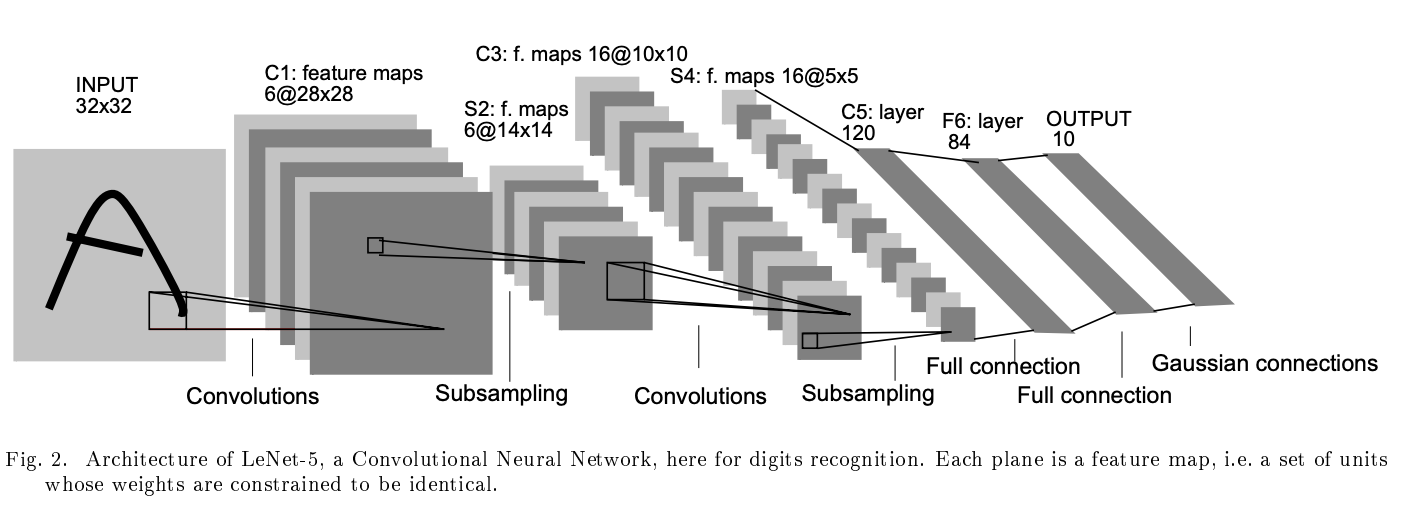

Let's implememt one of the classical convolutional network and apply it for CIFA10. Here is the link for the [original paper](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf) of LeNet5 introduced by Yann LeCun and colleagues in 1998. The original implentation of LeNet5 has Tanh as non-linearities. In 2012, AlexNet famously set off the deep learning revolution. AlexNet is based on LeNet, with two main innovations: (1) making it deeper by adding a few extra layers and (2) replacing the tanh activation functions by ReLU to improve training. Here we'll the original LeNet5 architecture to keep the compute requirements small, but work with the more modern ReLU activation functions.

One more thing we change in the original network is the number of input channels as LeNet5 was designed for grayscale MNIST dataset, where each picture has 1 channel, while for RGB pictures we have 3 channels in the input data.


In [26]:
class LeNet5(nn.Module):

    def __init__(self, n_classes, in_channels=1):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            ## TODO: add remaining layers, pooling and nonlinearities up to layer C5
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=16*5*5, out_features=120),
            ## TODO: add ReLU nonlinearity and final classification linear layer
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=n_classes)
    
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [27]:
## TODO: define network, put it to the device and train mode
n_classes = 10 

# Create an instance of LeNet5
lenet_model = LeNet5(n_classes,3)

lenet_model = lenet_model.to(device)

# Set the model to train mode
lenet_model.train()


LeNet5(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (classifier): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [28]:
## TODO: define loss function and optimisers
# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Define the optimizer
learning_rate = 0.001
optimizer = torch.optim.Adam(lenet_model.parameters(), lr=learning_rate)


In [29]:
## TODO: train with 20 epochs
num_epochs = 20
train_losses_lenet, val_losses_lenet, train_accs_lenet, val_accs_lenet = run_training(lenet_model, optimizer, loss_fn, device, num_epochs, train_loader, test_loader)



Epochs: 100%|██████████| 196/196 [00:19<00:00, 13.35epoch/s]
                                                            
Epochs: 100%|██████████| 196/196 [00:17<00:00, 13.21epoch/s]
                                                            
Epochs: 100%|██████████| 196/196 [00:15<00:00, 14.08epoch/s]
                                                            
Epochs:  99%|█████████▉| 195/196 [00:16<00:00, 12.31epoch/s]
                                                            
Epochs: 100%|██████████| 196/196 [00:15<00:00, 13.48epoch/s]
                                                            
Epochs: 100%|██████████| 196/196 [00:16<00:00, 13.99epoch/s]
                                                            
Epochs:  99%|█████████▉| 195/196 [00:18<00:00, 11.14epoch/s]
                                                            
Epochs: 100%|██████████| 196/196 [00:16<00:00, 13.93epoch/s]
                                                            
Epochs:  99%|█████████▉|

## Analysis 

In [30]:
# TODO write a plot function
import pandas as pd
def plot_loss(train_losses, val_losses,num_epochs,title):
    trainloss_data = {'epoch': range(1,num_epochs+1), 'train_loss': train_losses, 'val_loss': val_losses}
    df = pd.DataFrame(trainloss_data)
    df.plot(x='epoch', xticks=df.epoch, figsize=(10, 6),title=title)
    
def plot_acc(train_accs, val_accs,num_epochs,title):
    trainacc_data = {'epoch': range(1,num_epochs+1), 'train_accuracy': train_accs, 'val_accuracy': val_accs}
    df = pd.DataFrame(trainacc_data)
    df.plot(x='epoch', xticks=df.epoch, figsize=(10, 6),title=title)

In [31]:
## TODO: Plot both train and val losses for all models. 
plot_loss(train_losses_LR, val_losses_LR,num_epochs, "LR")
plot_loss(train_losses_MLP, val_losses_MLP,num_epochs, "MLP without Regularization")
plot_loss(train_losses_MLP2, val_losses_MLP2,num_epochs, "MLP with Regularization")
plot_loss(train_losses_lenet, val_losses_lenet,num_epochs,"Lenet")
## What do you see?
"""
The loss of the LR model shows a nonconverging pattern for the val and overfits as well

The MLP without regularisation show a massive overfitting

The MLP model with regularization shows a  large gap between the training loss and 
validation loss suggests that the model has become too specialized in fitting 
the training examples,including the noise and specific patterns unique to the training set.

The loss of the lenet shows a little overfitting as the validation loss starts to increase
after some epochs but the training loss continues to decrease

SyntaxError: incomplete input (4260912981.py, line 7)

In [ ]:
## TODO: Plot both train and val accuracies for all models. 
plot_acc(train_accs_LR, val_accs_LR,num_epochs, "LR")
plot_acc(train_accs_MLP, val_accs_MLP,num_epochs, "MLP without Regularization")
plot_acc(train_accs_MLP2, val_accs_MLP2,num_epochs, "MLP with Regularization")
plot_acc(train_accs_lenet, val_accs_lenet,num_epochs,"Lenet")
## What do you see?

"""
The LR model has the worst accuracies amongst all the models which could be due to the 
fact that it is the simplest model amongst them
The MLP model massively overfits witout regularization as training accuracy heads to
75% whilst val acc heads towards 55%
The lenet model accuracy although underwhelming shows a gradual growth which shows convergence and
the model is not overfitting
"""

In [ ]:
## TODO: Plot the confusion matrix for LeNet5
cm = calc_confusion_values(test_loader, lenet_model, device)
# Plot the confusion matrix
class_labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
                'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add labels to each cell
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), ha='center', va='center',
                 color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.show()

## Questions
* How did regularization change the performance of the MLP? Why?
* Explain the confusion matrix for LeNet5. What do you see there?
* Explain the difference in peformance between linear regression, MLP, and LeNet5.
* Why are convolutions better suited for pictures? Which properties of images do they exploit?
* Is it important to redefine an optimizer for each different model, training? What about loss functions?



## Additional experiments (Optional)
* Try to replace CIFAR10 dataset with MNIST. What do you notice? Why? Try to explain the differences in terms of variance or dataset complexity
